# Insect bite identification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from PIL import Image
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
import keras

# The dataset

In [2]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d bjoernjostein/tick-and-mosq
!unzip -q tick-and-mosq.zip -d insectbite
!rm tick-and-mosq.zip

  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 61.8MB/s]


In [5]:
data_dir = '/content/insectbite/data'

print("Number of samples in - ")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print('\n'+f.upper())
        for fx in os.listdir(data_dir + '/' + f + '/'):
            print(fx, " : ", len(os.listdir(data_dir + '/' + f +'/' + fx + '/')))

Number of samples in - 

TEST
tick  :  2
mosquito  :  2

TRAIN
tick  :  26
mosquito  :  21

VALIDATION
tick  :  5
mosquito  :  5


In [6]:
batch = 8

# The train, val and test datasets
print("Train dataset")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/train', batch_size=batch)

print("Validation dataset")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/validation', batch_size=batch)

print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir+'/test', batch_size=batch)

Train dataset
Found 47 files belonging to 2 classes.
Validation dataset
Found 10 files belonging to 2 classes.
Test dataset
Found 4 files belonging to 2 classes.


In [7]:
# Looking into the class names

class_names = train_ds.class_names
print(class_names)

['mosquito', 'tick']


# Visualization

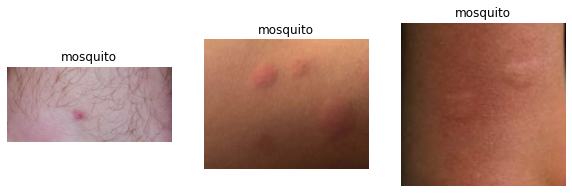

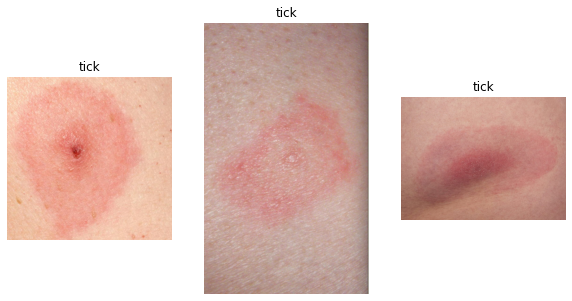

In [8]:
num_samples = 3    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(data_dir + '/train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(data_dir + '/train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

# Preprocessing

In [9]:
# Looking into the shape of the batches and individual samples
# Set the input shape

print("Looking into the shape of images and labels in one batch\n")  

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (8, 256, 256, 3)
Shape of images labels for one batch:  (8,)


In [10]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
# Augmenting images in the train set to increase dataset size

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),    # Flip along both axes
        layers.experimental.preprocessing.RandomZoom(0.1),    # Randomly zoom images in dataset
        layers.experimental.preprocessing.RandomRotation((-0.1, 0.1))
    ])


print("Train size (number of batches) before augmentation: ", len(train_ds))

# Apply only to train set    
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Size (number of batches) of augmented dataset: ", len(aug_ds))

#Adding to train_ds
train_ds = train_ds.concatenate(aug_ds)

print("Train size (number of batches) after augmentation: ", len(train_ds))

Train size (number of batches) before augmentation:  6
Size (number of batches) of augmented dataset:  6
Train size (number of batches) after augmentation:  12


# The model

In [25]:
base_model = keras.applications.VGG16(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

58892288/58889256 [==============================] - 0s 0us/step


In [26]:
cb = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [27]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(0.01), metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks=cb)

Epoch 1/32
12/12 [==============================] - 8s 410ms/step - loss: 0.8370 - accuracy: 0.3913 - val_loss: 0.7414 - val_accuracy: 0.5000
Epoch 2/32
12/12 [==============================] - 2s 127ms/step - loss: 0.7150 - accuracy: 0.5435 - val_loss: 0.6619 - val_accuracy: 0.5000
Epoch 3/32
12/12 [==============================] - 2s 128ms/step - loss: 0.6517 - accuracy: 0.5180 - val_loss: 0.6395 - val_accuracy: 0.7000
Epoch 4/32
12/12 [==============================] - 2s 128ms/step - loss: 0.6405 - accuracy: 0.7151 - val_loss: 0.6496 - val_accuracy: 0.7000
Epoch 5/32
12/12 [==============================] - 2s 127ms/step - loss: 0.6417 - accuracy: 0.5831 - val_loss: 0.6628 - val_accuracy: 0.5000
Epoch 6/32
12/12 [==============================] - 2s 127ms/step - loss: 0.6059 - accuracy: 0.6111 - val_loss: 0.6569 - val_accuracy: 0.6000
Epoch 7/32
12/12 [==============================] - 2s 126ms/step - loss: 0.6273 - accuracy: 0.6432 - val_loss: 0.7857 - val_accuracy: 0.5000
Epoch 

In [28]:
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(0.001), metrics=['accuracy'])

history2 = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks=cb)

Epoch 1/32
12/12 [==============================] - 2s 146ms/step - loss: 0.6191 - accuracy: 0.7696 - val_loss: 0.6425 - val_accuracy: 0.8000
Epoch 2/32
12/12 [==============================] - 2s 126ms/step - loss: 0.6147 - accuracy: 0.7307 - val_loss: 0.6452 - val_accuracy: 0.7000
Epoch 3/32
12/12 [==============================] - 2s 125ms/step - loss: 0.6230 - accuracy: 0.7221 - val_loss: 0.6482 - val_accuracy: 0.7000
Epoch 4/32
12/12 [==============================] - 2s 126ms/step - loss: 0.6286 - accuracy: 0.6555 - val_loss: 0.6405 - val_accuracy: 0.8000
Epoch 5/32
12/12 [==============================] - 2s 127ms/step - loss: 0.6100 - accuracy: 0.7689 - val_loss: 0.6427 - val_accuracy: 0.8000
Epoch 6/32
12/12 [==============================] - 2s 128ms/step - loss: 0.6024 - accuracy: 0.7186 - val_loss: 0.6446 - val_accuracy: 0.8000
Epoch 7/32
12/12 [==============================] - 2s 127ms/step - loss: 0.6174 - accuracy: 0.6831 - val_loss: 0.6433 - val_accuracy: 0.8000
Epoch 

In [29]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.7042 - accuracy: 0.7500


[0.7041611671447754, 0.75]

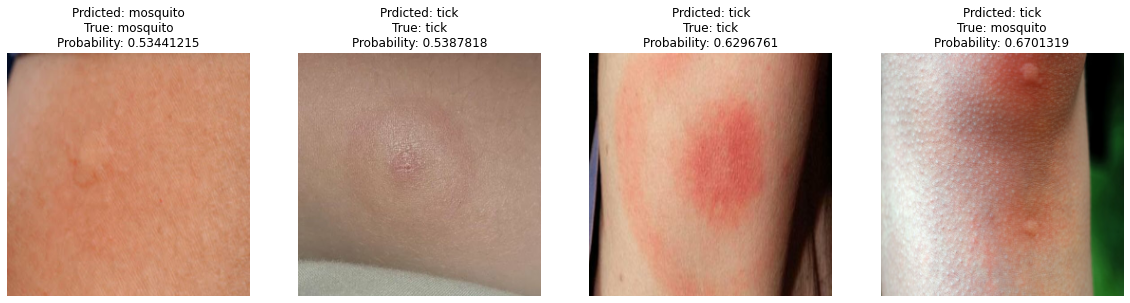

In [33]:
# prediction for all samples in the test dataset

plt.figure(figsize=(20, 20))

for i in test_ds.as_numpy_iterator():
    img, label = i  
    for x in range(len(label)):  
        ax = plt.subplot(1, len(label), x + 1)
        plt.axis('off')   # remove axes
        plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
        output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
        pred = np.argmax(output[0])    # finding max
        t = "Prdicted: " + class_names[pred]    # Picking the label from class_names base don the model output
        t = t + "\nTrue: " + class_names[label[x]]
        t = t + "\nProbability: " + str(output[0][pred])
        plt.title(t)

In [34]:
model.save('insect.h5')